## Import the necessary Libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.spatial.distance import pdist, cdist, squareform
from matplotlib import pyplot as plt
import networkx as nx
import os
from sklearn.metrics import mean_squared_error
from pygsp import graphs
import scipy

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, clear_output
%matplotlib inline

In [2]:
DATA_PATH = '../data/ml-100k-convert/'
os.getcwd()
DATA_PATH = '../data/ml-100k-convert/'
GENERATED_PATH = '../generated/'
RESULT_PATH = '../results/'

## Load the ratings database

In [3]:
# Load data
lens_ratings = pd.read_csv(DATA_PATH+'data.tsv', sep='\t', names=['UserId', 'MovieId', 'Ratings', 'Timestamp'])
print(lens_ratings.shape)
# Get rid of timestamp
lens_ratings = lens_ratings.drop(columns=['Timestamp'])
lens_ratings.head()

(100000, 4)


,UserId,MovieId,Ratings
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


Look at some of the features of the Data

In [4]:
nb_users = len(lens_ratings.UserId.unique())
nb_movies = len(lens_ratings.MovieId.unique())
print('There are {} users'.format(nb_users))
print('There are {} movies'.format(nb_movies))

movies = pd.read_csv(GENERATED_PATH+'final_movies.csv')
movies_id = movies['ML-100k-convertId'].to_list()
lens_ratings = lens_ratings[lens_ratings.MovieId.isin(movies_id)]
lens_ratings

There are 943 users
There are 1682 movies


,UserId,MovieId,Ratings
1,186,302,3
3,244,51,2
4,166,346,1
6,115,265,2
8,305,451,3
...,...,...,...
99991,676,538,4
99992,721,262,3
99995,880,476,3
99996,716,204,5


In [5]:
# Pivot the table, put 0 when there are no ratings
ratings = pd.pivot_table(lens_ratings, index='UserId', columns='MovieId', values='Ratings', fill_value=0)




#ratings = pd.read_csv(GENERATED_PATH+'ratings_matrix.csv', index_col=0)
ratings.shape

(943, 480)

We genereate a test and a learning dataset based on a 70:30 split. The mask is randomly distributed over the whole pivot table.

In [6]:
mask = np.random.rand(*ratings.shape) < 0.7
ratings_np = ratings.to_numpy()
rating_train = ratings_np.copy()
rating_test = ratings_np.copy()
rating_train[~mask] = 0
rating_test[mask] = 0
mask.shape

(943, 480)

What is the distrubition of movies rated by a user?
as well as the maximum and minimum ratings:

Number of movies rated per user: mean: 62.8, max: 4, min: 304


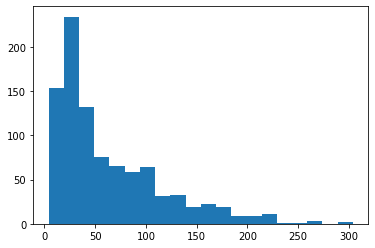

In [7]:
plt.hist(np.count_nonzero(ratings, axis=1),bins=20)
cnt = np.count_nonzero(ratings, axis=1)
print(f'Number of movies rated per user: mean: {cnt.mean():.1f}, max: {cnt.min()}, min: {cnt.max()}')

Here we define distance and weight functions that can be used with pdist and cdist to generate a distance matrix of the users.

In [8]:
def user_distance(ratingsA, ratingsB):
    #print(len(ratingsA),len(ratingsB))
    diff_ratings = []
    n = 0
    for x, y in zip(ratingsA, ratingsB):
        if x != 0 and y != 0:
            n += 1
            diff_ratings.append((x - y)**2)
    if diff_ratings:
        return np.mean(diff_ratings) / n
    else:
        return np.inf
    
def user_distance2(ratingsA, ratingsB):
    mask = np.intersect1d(ratingsA.nonzero()[0], ratingsB.nonzero()[0])
    diff_ratings = ((ratingsA[mask] - ratingsB[mask])**2)
    if diff_ratings.shape[0] > 0:
        cA = np.count_nonzero(ratingsA)
        cB = np.count_nonzero(ratingsB)
        #print(cA, cB, min(cA, cB))
        return np.mean(diff_ratings) + 1 * (1 / diff_ratings.shape[0]) ** 2 + 0.6 * (np.abs(cA - cB) / min(cA, cB))**2.
    else:
        return np.inf
    
def user_weight_simple(ratingsA, ratingsB):
    if np.count_nonzero(ratingsA) == 0:
        return 0
    mask = np.intersect1d(ratingsA.nonzero()[0], ratingsB.nonzero()[0])
    diff_ratings = np.abs((ratingsA[mask] - ratingsB[mask]))
    return np.sum(4 - diff_ratings) / (np.count_nonzero(ratingsA))

def count_intersect(ratingsA, ratingsB):
    mask = np.intersect1d(ratingsA.nonzero()[0], ratingsB.nonzero()[0])
    diff_ratings = np.abs((ratingsA[mask] - ratingsB[mask]))
    return diff_ratings.shape[0]

Here a little sample rating file is defined with arbitrary numbers, that can be used to check the output

In [9]:
#weight_matrix_raw = squareform(pdist(ratings_norm, user_weight_simple))
ratings_sample = ([[0,1,5,0,3,1,0],[3,3,3,3,0,0,0],[0,5,1,0,1,4,0],[4,5,1,0,0,5,0]])
pd.DataFrame(ratings_sample)

,0,1,2,3,4,5,6
0,0,1,5,0,3,1,0
1,3,3,3,3,0,0,0
2,0,5,1,0,1,4,0
3,4,5,1,0,0,5,0


## Calculate the distance between all the users. 
This matrix will not be symmetric, hence we use the cdist.

In [10]:
weight_matrix_raw = (cdist(rating_train, rating_train, user_weight_simple))
np.fill_diagonal(weight_matrix_raw,0)

Look at the structure of `weight_matrix_raw`

In [11]:
print(f'nan count: {np.count_nonzero(np.isnan(weight_matrix_raw))}')
plt.show()
print(f'min: {np.min(weight_matrix_raw):.3f}, max: {np.max(weight_matrix_raw):.3f}, mean: {np.mean(weight_matrix_raw):.3f}')
pd.DataFrame(weight_matrix_raw)

nan count: 0
min: 0.000, max: 3.600, mean: 0.504


,0,1,2,3,4,5,6,7,8,9,...,933,934,935,936,937,938,939,940,941,942
0,0.000000,0.161017,0.076271,0.050847,0.779661,0.830508,1.296610,0.432203,0.033898,0.813559,...,0.779661,0.220339,0.432203,0.084746,0.254237,0.135593,0.533898,0.169492,0.305085,0.855932
1,0.826087,0.000000,0.478261,0.391304,0.304348,1.521739,0.956522,0.260870,0.347826,0.913043,...,0.695652,0.652174,1.608696,0.739130,0.608696,0.434783,0.869565,0.478261,0.695652,0.304348
2,0.375000,0.458333,0.000000,0.333333,0.125000,0.500000,0.625000,0.416667,0.083333,0.208333,...,0.000000,0.250000,0.791667,0.333333,0.625000,0.000000,0.500000,0.208333,0.166667,0.291667
3,0.750000,1.125000,1.000000,0.000000,0.000000,0.750000,0.875000,0.375000,0.500000,0.500000,...,0.375000,0.375000,0.625000,0.875000,1.500000,0.000000,0.625000,0.375000,1.375000,0.375000
4,1.559322,0.118644,0.050847,0.000000,0.000000,0.491525,1.033898,0.677966,0.000000,0.525424,...,0.627119,0.135593,0.338983,0.000000,0.423729,0.186441,0.440678,0.203390,0.271186,0.983051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,0.800000,0.500000,0.000000,0.000000,0.550000,0.550000,0.750000,0.350000,0.200000,0.200000,...,0.700000,1.200000,1.000000,0.500000,1.850000,0.000000,0.250000,0.600000,0.200000,0.750000
939,1.235294,0.392157,0.235294,0.098039,0.509804,1.352941,1.352941,0.568627,0.176471,1.078431,...,0.686275,0.098039,0.470588,0.254902,0.490196,0.098039,0.000000,0.156863,0.490196,0.823529
940,1.428571,0.785714,0.357143,0.214286,0.857143,1.000000,0.428571,0.785714,0.285714,0.500000,...,0.285714,1.071429,1.642857,0.285714,1.714286,0.857143,0.571429,0.000000,0.500000,0.642857
941,1.028571,0.457143,0.114286,0.314286,0.457143,0.742857,1.285714,0.514286,0.000000,0.628571,...,0.828571,0.171429,0.371429,0.342857,0.285714,0.114286,0.714286,0.200000,0.000000,0.942857


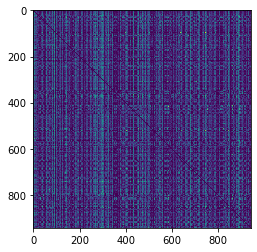

In [12]:
plt.imshow(weight_matrix_raw)
plt.show()

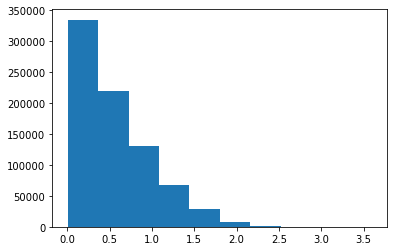

In [13]:
plt.hist(weight_matrix_raw[weight_matrix_raw > 0].flatten())
plt.show()

The following cells can be used to determine the number of commonly rated movies between two users. 

intersect_matrix = squareform(pdist(rating_train, count_intersect))

## Prediction function
Here we define the prediction function
It takes the weights of one user to the other users, as well as the rating table as input. 
The weights vector for the users is expand to a matrix of the size of the ratings and we set the weights for the unrated movies to zeros. This makes it possible to normalize the weights of each movie row. This matrix is element-wise multiplied with the given ratings matrix. Finally the weighted ratings for every movie are summed, to get a predicted rating for every movie

In [14]:
def predictRating(user_corr, ratings ):
    rating_mask = (ratings != 0).astype(float)
    #user_corr = np.random.rand(user_corr.shape[0])
    #user_corr = np.random.rand(user_corr.shape[0])
    user_corr = user_corr
    #user_corr[user_corr == 4] = 0
    #np.kron(user_corr[:4])
    #user_corr[:4].shape)
    user_corr_expand = (np.ones((ratings.shape[1],1)) @ (user_corr.reshape((1,user_corr.shape[0])))).T * rating_mask 
    user_corr_exp_norm = user_corr_expand / (user_corr_expand.sum(axis=0)[np.newaxis, :] + 1E-10)
    user_corr_exp_norm[np.isnan(user_corr_exp_norm)] = 0
    weighted_ratings = ratings * user_corr_exp_norm
    pred_rating = weighted_ratings.sum(axis = 0)
    return pred_rating

We for the graph we want to use a gaussian kernel and the epsilon similarity graph, which leads to a more centralized sparsified graph. We decided to use an epsilon value of 0.2, but tried to find the sweep spot to for the `sigma` using search algorithms. First a simple line search and further using `scipy.minimize`.

Define an epsilon kernel (epsilon similarity matrix)
An RBF kernel is usedt to set the edge weights $w_{ij}=\exp(-||x_i- x_j||_2^2 / ~ 2 \sigma^2)$ for the adjacency matrix and resulting values below the `epsilon` are set to `0`

In [15]:
def epsilon_kernel(X: np.ndarray, sigma=1, epsilon=0):
    """ X (n x d): distance matrix
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """
    adjacency = np.exp( - X ** 2 / (2 * (sigma ** 2)))
    adjacency[adjacency < epsilon] = 0
    np.fill_diagonal(adjacency, 0)
    return adjacency

In [16]:
def optimize_epsilon(x):
    sigma, epsilon = x
    #epsilon_weight = epsilon_kernel(4 - weight_matrix_raw.copy(), sigma=sigma, epsilon=epsilon) 
    epsilon_weight = epsilon_kernel(4 - weight_matrix_raw.copy(), sigma=sigma, epsilon=epsilon) 

    errors = []
    for ii in range(weight_matrix_raw.shape[0]):
        pred_rating = predictRating(epsilon_weight[ii,:].copy(), rating_train)  
        ratings_user = rating_train[ii,:]
        if np.count_nonzero(ratings_user) > 0:
            errors.append(np.sqrt(mean_squared_error(ratings_user[ratings_user != 0], (pred_rating[ratings_user != 0]))))
    clear_output(wait = True)
    print(np.mean(errors), x)
    plt.spy(epsilon_weight)
    plt.show()
    return np.mean(errors)

0.9888336326972594 [3.0, 0.3]


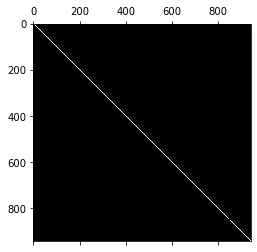

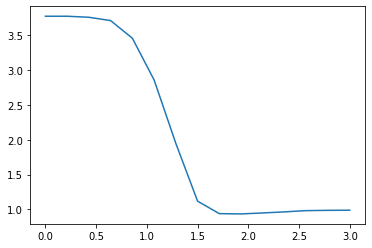

1.9285714285714284 0.9356327596101671


In [17]:
error_sigma = []
sigmas  = np.linspace(0,3,15)
for i in sigmas:
    error_sigma.append(optimize_epsilon([i,0.3]))
    plt.plot(sigmas[:len(error_sigma)],error_sigma)
    plt.show()
    best_sigma = sigmas[np.argmin(error_sigma)]
    print(best_sigma, np.min(error_sigma))

0.9357756303403917 [1.92, 0.3]


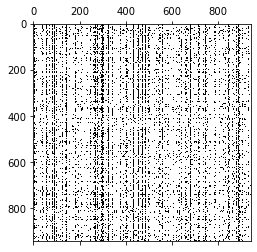

0.9357756303403917

In [18]:
x0 = [1.92, 0.3 ]
optimize_epsilon(x0)

In [19]:
optimize_epsilon_bool = False
if optimize_epsilon_bool:
    epsilon_res = scipy.optimize.minimize(optimize_epsilon, x0)
    x0 = epsilon_res['x']
    epsilon_res

Connected Components 1


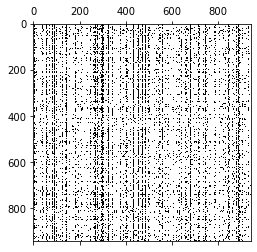

In [20]:
weight_matrix = epsilon_kernel(4 - weight_matrix_raw.copy(), sigma=x0[0], epsilon=x0[1])
np.diag(weight_matrix, 0)
plt.spy(weight_matrix)
graph = nx.from_numpy_array(weight_matrix)
print('Connected Components',nx.number_connected_components(graph))

np.savetxt(GENERATED_PATH+'user_ratings_adj.csv', weight_matrix, delimiter=',')
nx.write_gexf(graph, GENERATED_PATH + 'user_kernel.gexf')

perfom a prediction of user 20

In [21]:
i_user = 20

ratings_np.shape
rating_mask = (ratings_np != 0).astype(float)

In [22]:
## use the train dataset
pred_rating = predictRating(weight_matrix[i_user,:].copy(), rating_train)

Possibility to look at the different intermediate matrices.

In [23]:
pd.DataFrame(pred_rating).head()

,0
0,3.999343
1,3.007446
2,2.882240
3,3.443240
4,2.562201


(array([ 29.,   9.,   8.,  28.,  28.,  70.,  98., 105.,  77.,  28.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

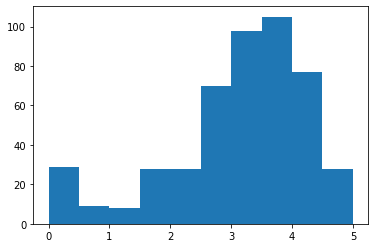

In [24]:
plt.hist(pred_rating)

We can see that the ratings are in the expected range and the structure of the distribution seems reasonable.

### Correlation display
Here we compare the ground truth rating (x-axis) with the predicted ratings. We see a trend in the right direction.

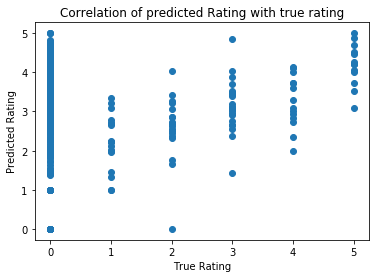

In [25]:
plt.scatter(ratings_np[i_user,:],pred_rating)
plt.title('Correlation of predicted Rating with true rating')
plt.ylabel('Predicted Rating')
plt.xlabel('True Rating')
plt.show()


We can see that the predictions are not perfect, but a clear correlation between the predictions can be seen.

The same grafik can be plotted by violinplots, which show the distribution of the predicted Ratings.
For this display we currently use all available ratings of the user.

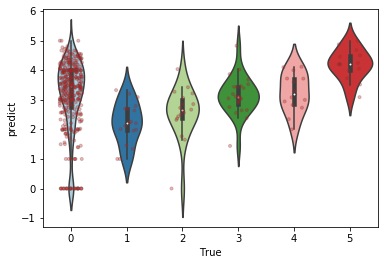

In [26]:
ratings_user = ratings_np[i_user,:]
mean_counter = ratings_np.copy().astype('float')
mean_counter[mean_counter == 0] = np.nan
mean_ratings = np.nanmean(mean_counter, axis = 0)
df = pd.DataFrame({ 'True' :ratings_np[i_user,:], 'predict' : pred_rating})
#df2 = pd.DataFrame({ 'True' : ratings_np[i_user,:] + 0.5, 'predict' : mean_ratings})
#df = pd.concat([df1, df2])


sns.violinplot(x='True', y='predict', data=df, palette='Paired') #,split=True)
sns.stripplot(x='True', y='predict', data=df, color="red",jitter=0.2,dodge=True, size=3, alpha=0.3,linewidth=1)

calculate the error of the predicted rating in comparison to the error of just taking the averages. 

In [27]:
error = np.sqrt(mean_squared_error(ratings_user[ratings_user != 0], pred_rating[ratings_user != 0]))
error_avg = np.sqrt(mean_squared_error(ratings_user[ratings_user != 0], mean_ratings[ratings_user != 0]))
print(error, error_avg, np.count_nonzero(ratings_user != 0))

1.0105384573209115 1.131941228658623 88


## all users
here we want to calculate the error for all ratings. Herefore we use the train split for the entire prediction part. Thereafter we use the test split to calculate the errors.

In [28]:
errors_all = []
train_errors = []
pred_ratings = np.zeros(ratings_np.shape)
for ii in range(weight_matrix.shape[0]):
    pred_rating = predictRating(weight_matrix[ii,:].copy(), rating_train)
    pred_ratings[ii,:] = pred_rating
    ratings_user = rating_test[ii,:]
    ratings_user_train = rating_train[ii,:]
    if np.count_nonzero(ratings_user) > 0:
        errors_all.append(np.sqrt(mean_squared_error(ratings_user[ratings_user != 0], (pred_rating[ratings_user != 0]))))
    if np.count_nonzero(ratings_user_train) > 0:
        train_errors.append(np.sqrt(mean_squared_error(ratings_user_train[ratings_user_train != 0], (pred_rating[ratings_user_train != 0]))))
    if ii % 10 == 0:
        clear_output(wait=True)
        print(f'Iteration {ii}')
        print(f'Mean RMSE: {np.mean(errors_all)}')
        print(f'Median RMSE: {np.median(errors_all)}')
        print(f'Train RMSE: {np.mean(train_errors)}')

Iteration 940
Mean RMSE: 0.9784874528549027
Median RMSE: 0.9390066216997055
Train RMSE: 0.935828393308925


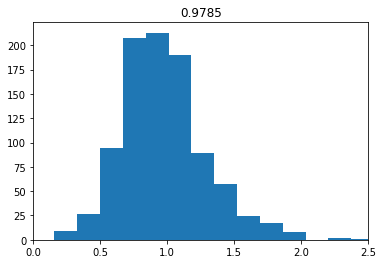

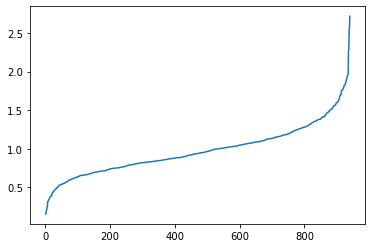

In [29]:
plt.hist(sorted(errors_all), bins=15)
plt.title(f'{np.average(errors_all):.4f}')
plt.xlim(0,2.5)
plt.show()
plt.plot(sorted(errors_all))
plt.show()

The histogram shows a peaked RMSE slightly below 1. From the distribution we see that more users have an RMSE below average which can also be seen by the median, which is lower.z

## Second run
It will be tested, if calculating a new graph based on the predicted ratings will improve the results.

In [30]:
ratings2 = pred_ratings.copy()
ratings2[rating_train != 0] = 0
ratings2 += rating_train

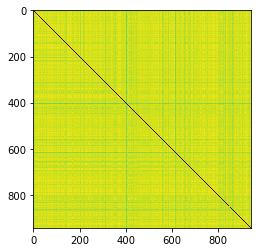

In [31]:
weight_matrix2 = squareform(pdist(ratings2, user_weight_simple))
np.fill_diagonal(weight_matrix2,0)
plt.imshow(weight_matrix2)

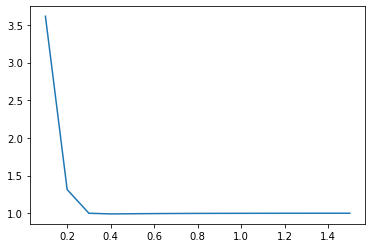

0.4 0.9913238523799657


In [32]:
error_sigma2 = []
sigmas  = np.linspace(0.1,1.5,15)
for i in sigmas:
    epsilon_weight = epsilon_kernel(4 - weight_matrix2.copy(), sigma=i, epsilon=0.3) 
    errors = []
    for ii in range(weight_matrix_raw.shape[0]):
        pred_rating = predictRating(epsilon_weight[ii,:].copy(), rating_train)  
        ratings_user = rating_train[ii,:]
        if np.count_nonzero(ratings_user) > 0:
            errors.append(np.sqrt(mean_squared_error(ratings_user[ratings_user != 0], (pred_rating[ratings_user != 0]))))
    error_sigma2.append( np.mean(errors))
    clear_output(wait=True)
    plt.plot(sigmas[:len(error_sigma2)],error_sigma2)
    plt.show()
    best_sigma2 = sigmas[np.argmin(error_sigma2)]
    print(best_sigma2, np.min(error_sigma2))

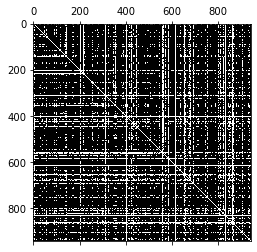

In [33]:
weight_matrix = epsilon_kernel(4 - weight_matrix2.copy(), sigma = 0.3, epsilon=0.3)
np.diag(weight_matrix, 0)
plt.spy(weight_matrix)
plt.show()

In [34]:
errors2 = []
pred_ratings2 = np.zeros(ratings_np.shape)
for ii in range(weight_matrix.shape[0]):
    pred_rating2 = predictRating(weight_matrix2[ii,:].copy(), rating_train)
    pred_ratings2[ii,:] = pred_rating2
    #pred_rating = predictRating(np.random.rand(nn_weight_mat.shape[0]), ratings_np)
    ratings_user = rating_test[ii,:]
    if np.count_nonzero(ratings_user) > 0:
        errors2.append(np.sqrt(mean_squared_error(ratings_user[ratings_user != 0], (pred_rating2[ratings_user != 0]))))
    #errors.append(np.sqrt(mean_squared_error(ratings_user[ratings_user != 0],(1+ 4 * np.random.rand(np.count_nonzero(ratings_user))))))
    if ii % 10 == 0:
        clear_output(wait=True)
        display(ii,np.average(errors2))

940

0.9920040993108239

This method did not improve the validation RMSE. 
Looking at the sparsity of the matrix we see that we do not have distinct differences between the users anymore, which results in a homogenification. In Conclusion a second run adds noise to data, while not providing new information.

## Graph based filtering
Another approach will be to use the movie feature graph and perform signal filtering to improve our results.

We will use the movie feature graph for this task, as it could provide further information for graph filtering.

(480, 480)

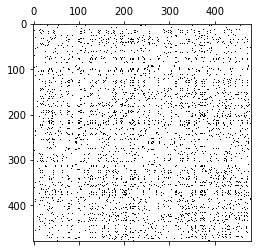

In [35]:
#adjacency = np.loadtxt(GENERATED_PATH+'movie_ratings_adj.csv', delimiter=',')
adjacency = np.loadtxt(GENERATED_PATH+'movie_features_adj.csv', delimiter=',')
plt.spy(adjacency)
adjacency.shape

In [36]:
G = graphs.Graph(adjacency)
G.set_coordinates()
G.compute_laplacian('normalized')
G.compute_fourier_basis()

/home/ng/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/pygsp/graphs/graph.py:496: RuntimeWarning: divide by zero encountered in power
  d = np.power(self.dw, -0.5)


In [37]:
ratings3 = pred_ratings.copy()

In [38]:
user = 2
signal = ratings3[user].copy()
mask = rating_train[user] != 0
val = (rating_test[user].copy()).astype(float)
val_mask = val != 0
val[~val_mask] = np.nan

In [39]:
fouriersig = G.gft(signal)

Text(0.5, 1.0, 'The graph signal')

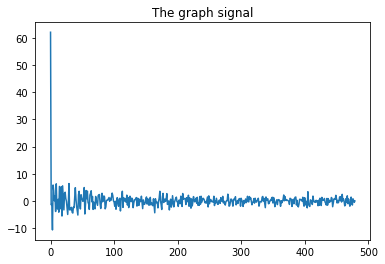

In [40]:
plt.plot(fouriersig)
plt.title('The graph signal')

In [41]:
def fit_polynomial(lam: np.ndarray, order: int, spectral_response: np.ndarray):
    """ Return an array of polynomial coefficients of length 'order'."""
    vander = np.vander(lam, order+1)
    return np.linalg.lstsq(vander, spectral_response)[0]

def polynomial_graph_filter_response(coeff: np.array, lam: np.ndarray):
    """ Return an array of the same shape as lam.
        response[i] is the spectral response at frequency lam[i]. """
    vander = np.vander(lam, len(coeff))
    return vander @ coeff

def polynomial_graph_filter(coeff: np.array, laplacian: np.ndarray):
    """ Return the laplacian polynomial with coefficients 'coeff'. """
    laplacian_poly = 0
    for i, coef in enumerate(coeff):
        deg = len(coeff) - i - 1
        laplacian_poly += coef * np.linalg.matrix_power(laplacian, deg)
    return laplacian_poly

## Tricky part 
here we have to get a good filter, which seems to be hard.

In [42]:
ideal_lp = np.ones((G.N,))
ideal_lp[G.e < 1.005] = 0  # Low-pass filter with cut-off at lambda=0.1
ideal_lp[G.e > 1.6] = 0  # Low-pass filter with cut-off at lambda=0.1
ideal_filter = ideal_lp# Store your spectral response here

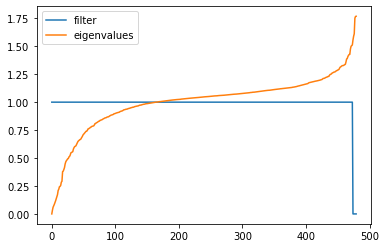

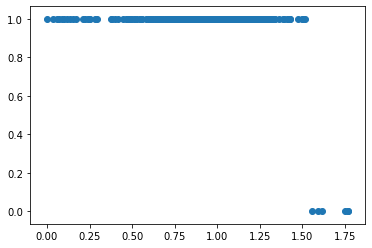

In [43]:
#alpha = 0.99 / np.max(G.e)

#ideal_filter =  1/(1 + alpha*G.e)
ideal_filter = np.ones(G.e.shape)
#ideal_filter[G.e < 0.1] = 0
ideal_filter[G.e > 1.55] = 0
plt.plot(ideal_filter, label = 'filter')
plt.plot(G.e, label = 'eigenvalues')
plt.legend()
plt.show()
plt.scatter(G.e, ideal_filter)
plt.show()

In [44]:
order =  4

coeff = fit_polynomial(G.e, order, ideal_filter)
graph_filter = polynomial_graph_filter(coeff, G.L.A)
coeff

/home/ng/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


array([-1.21981066,  3.41631203, -3.13408129,  1.01097341,  0.92933068])

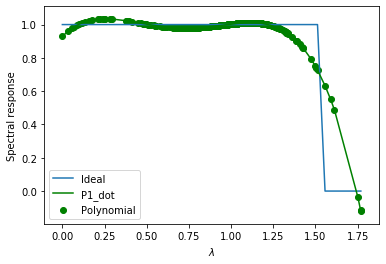

In [45]:
#coeff=[0,0,0,1]
plt.plot(G.e, ideal_filter)
plt.scatter(G.e, polynomial_graph_filter_response(coeff, G.e),color='green')
# plt.yl
plt.plot(G.e, polynomial_graph_filter_response(coeff, G.e),'g')
plt.legend(['Ideal','P1_dot', 'Polynomial'])
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')
plt.show()

In [46]:
#coeff = [ 0.34618805, -0.53866174,  0.01293408,  1.11032241]

In [47]:

graph_gcn_filter = polynomial_graph_filter(coeff, G.L.A)

In [48]:
signal_filtered = (graph_gcn_filter) @ signal
signal_filtered_val = signal_filtered.copy()
signal_filtered_val[~val_mask] = np.nan

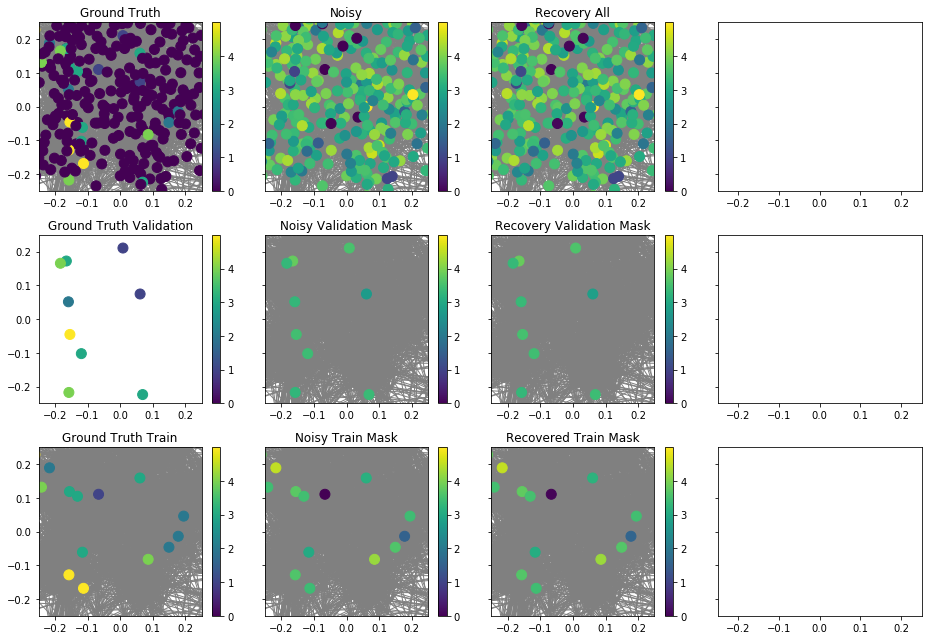

In [65]:
fig, ax = plt.subplots(3, 4, sharey=True, figsize=(13, 9))
limits = [signal.min(), signal.max()]
_ = G.plot_signal(ratings_np[user], ax=ax[0,0], limits=limits, plot_name='Ground Truth')

_ = G.plot_signal(signal, ax=ax[0,1], limits=limits, plot_name='Noisy')
signal_red = signal.copy()
signal_red[~val_mask] = np.nan
_ = G.plot_signal(signal_red, ax = ax[1,1], limits = limits, plot_name = 'Noisy Validation Mask')
_ = G.plot_signal(val, ax=ax[1,0], limits=limits, plot_name='Ground Truth Validation', show_edges=False)
_ = G.plot_signal(signal_filtered, ax=ax[0,2], limits=limits, plot_name='Recovery All')
_ = G.plot_signal(signal_filtered_val, ax=ax[1,2], limits=limits, plot_name='Recovery Validation Mask')

ground_train = ratings_np[user].copy().astype(float)
signal_train = signal.copy()
filtered_train = signal_filtered.copy()
ground_train[~mask] = np.nan
signal_train[~mask] = np.nan
filtered_train[~mask] = np.nan
_ = G.plot_signal(ground_train, ax=ax[2,0], limits=limits, plot_name='Ground Truth Train')
_ = G.plot_signal(signal_train, ax=ax[2,1], limits=limits, plot_name='Noisy Train Mask')
_ = G.plot_signal(filtered_train, ax=ax[2,2], limits=limits, plot_name='Recovered Train Mask')
for i,av in enumerate(ax):
    for j, v in enumerate(av):
        ax[i,j].set_ylim([-0.25,0.25])
        ax[i,j].set_xlim([-0.25,0.25])
_ = fig.tight_layout()

In [50]:
print(np.sqrt(mean_squared_error(val[val_mask], signal[val_mask])),
np.sqrt(mean_squared_error(val[val_mask], signal_filtered[val_mask])))

1.3376885269332242 1.2446593295486013


Here we see that for the current filter. The signal validation data will be worsened by additional graph filtering.

In [51]:
test_range = range(weight_matrix.shape[0])
count_met = 0
def filter_fit(coeff, signal, G):
    graph_filter = polynomial_graph_filter(coeff, G.L.A)
    error = 0
#     l = range(weight_matrix.shape[0])
   # l = range(1)
    l = test_range
    for ii in l:
        signal_filtered = np.abs(graph_filter) @ ratings3[ii]
        ratings_user = rating_train[ii,:]
        if np.count_nonzero(ratings_user) > 0:
            error += np.sqrt(mean_squared_error(ratings_user[ratings_user != 0], (signal_filtered[ratings_user != 0])))
    print(error / len(l), l)
    return error / len(l)

def filter_callback(xk):    
    error_train = 0
    error_val = 0
#     l =  range(weight_matrix.shape[0])
    graph_filter = polynomial_graph_filter(xk, G.L.A)
    l = test_range
    for ii in l:
        signal_filtered = np.abs(graph_filter) @ ratings3[ii]
        ratings_val = rating_test[ii,:]
        ratings_train = rating_train[ii,:]
        if np.count_nonzero(ratings_val) > 0 and np.count_nonzero(ratings_train) > 0:
            error_val += np.sqrt(mean_squared_error(ratings_val[ratings_val != 0], (signal_filtered[ratings_val != 0])))
            error_train += np.sqrt(mean_squared_error(ratings_train[ratings_train != 0], (signal_filtered[ratings_train != 0])))
    error_train /= len(l)
    error_val /= len(l)
    filter_error_evol.append(error_train)
    filter_error_evol_val.append(error_val)
    
    clear_output(wait=True)
    print(xk)
    plt.semilogy(filter_error_evol)
    plt.semilogy(filter_error_evol_val)
   # plt.ylim(0.5,1.05)
    plt.show()
    print(f'train error: {error_train:.5f}, validation error: {error_val:.5f}')
    plt.plot(G.e, np.abs(polynomial_graph_filter_response(xk, G.e)),'g')
    plt.show()
    plt.show()

[-0.06396027  0.15934823 -0.15223449  0.07691981  0.97359329]


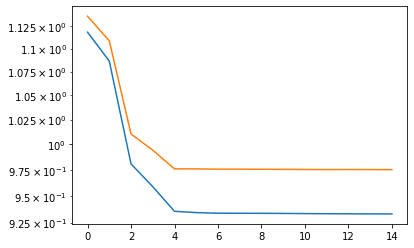

train error: 0.93311, validation error: 0.97519


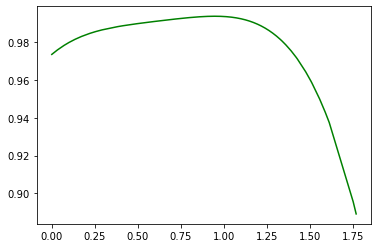

Optimization terminated successfully.
         Current function value: 0.935164
         Iterations: 13
         Function evaluations: 133
         Gradient evaluations: 19


      fun: 0.9351643428517368
 hess_inv: array([[ 5.31421514, -5.02421422, -5.92132255,  5.83008066, -0.44834462],
       [-5.02421422,  5.04280191,  5.18191082, -5.43079045,  0.478746  ],
       [-5.92132255,  5.18191082,  7.44821615, -6.94652196,  0.53697517],
       [ 5.83008066, -5.43079045, -6.94652196,  6.88942334, -0.652387  ],
       [-0.44834462,  0.478746  ,  0.53697517, -0.652387  ,  0.14462472]])
      jac: array([0.00645679, 0.00580465, 0.00440297, 0.00415765, 0.00338232])
  message: 'Optimization terminated successfully.'
     nfev: 133
      nit: 13
     njev: 19
   status: 0
  success: True
        x: array([-0.06396027,  0.15934823, -0.15223449,  0.07691981,  0.97359329])

In [52]:
filter_error_evol = []
filter_error_evol_val = []
filter_callback([0,0,-0.4,-0,1])
x0 =[-0.00,0,-0.4,-0,1] + np.random.rand(5) / 20 
filter_callback(x0)
#print(np.sqrt(mean_squared_error(val[val != np.nan], signal[val != np.nan])))
filter_res = scipy.optimize.minimize(filter_fit, x0, args= (signal, G), options = {'disp' : True}, callback = filter_callback, tol = 1E-2)
coeff = filter_res.x
graph_filter = polynomial_graph_filter(coeff, G.L.A)
#print(np.sqrt(mean_squared_error(val[val != np.nan], ((graph_filter @ signal)[val != np.nan]))))
filter_res

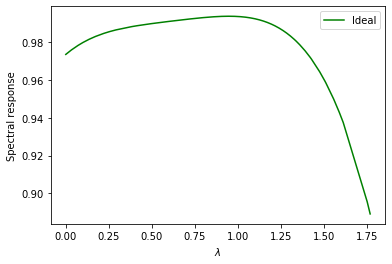

In [53]:

plt.plot(G.e, polynomial_graph_filter_response(coeff, G.e),'g')
plt.legend(['Ideal','P1_dot', 'Polynomial'])
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')
plt.show()

In [54]:
graph_gcn_filter = polynomial_graph_filter(coeff, G.L.A)

signal_filtered = np.abs(graph_gcn_filter) @ signal
signal_filtered_val = signal_filtered.copy()
signal_filtered_val[~val_mask] = np.nan

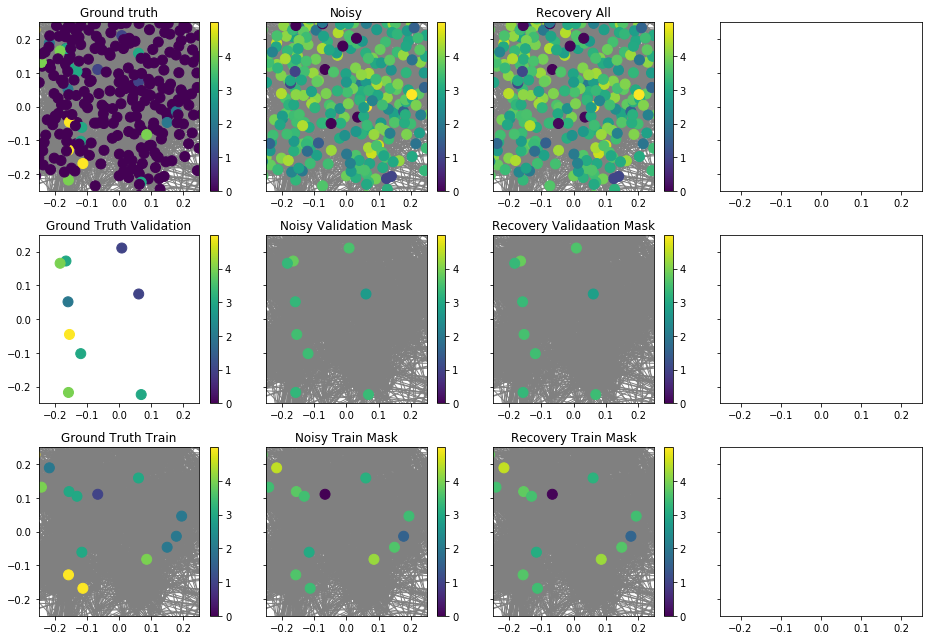

In [64]:
fig, ax = plt.subplots(3, 4, sharey=True, figsize=(13, 9))
limits = [signal.min(), signal.max()]
_ = G.plot_signal(ratings_np[user], ax=ax[0,0], limits=limits, plot_name='Ground truth')

_ = G.plot_signal(signal, ax=ax[0,1], limits=limits, plot_name='Noisy')
signal_red = signal.copy()
signal_red[~val_mask] = np.nan
_ = G.plot_signal(signal_red, ax = ax[1,1], limits = limits, plot_name = 'Noisy Validation Mask')
_ = G.plot_signal(val, ax=ax[1,0], limits=limits, plot_name='Ground Truth Validation', show_edges=False)
_ = G.plot_signal(signal_filtered, ax=ax[0,2], limits=limits, plot_name='Recovery All')
_ = G.plot_signal(signal_filtered_val, ax=ax[1,2], limits=limits, plot_name='Recovery Validaation Mask')

ground_train = ratings_np[user].copy().astype(float)
signal_train = signal.copy()
filtered_train = signal_filtered.copy()
ground_train[~mask] = np.nan
signal_train[~mask] = np.nan
filtered_train[~mask] = np.nan
_ = G.plot_signal(ground_train, ax=ax[2,0], limits=limits, plot_name='Ground Truth Train')
_ = G.plot_signal(signal_train, ax=ax[2,1], limits=limits, plot_name='Noisy Train Mask')
_ = G.plot_signal(filtered_train, ax=ax[2,2], limits=limits, plot_name='Recovery Train Mask')
for i,av in enumerate(ax):
    for j, v in enumerate(av):
        ax[i,j].set_ylim([-0.25,0.25])
        ax[i,j].set_xlim([-0.25,0.25])
_ = fig.tight_layout()

In [56]:
# graph_filter = polynomial_graph_filter(coeff, G.L.A)
# error = []
# for i in range(10):
#     signal_filtered = (graph_filter) @ ratings3[ i]
#     val_it = rating_test[i].copy().astype(float)
#     error += np.sqrt(mean_squared_error(val_it[val_it != 0], signal_filtered[val_it != 0]))

In [66]:
print('Old Error', np.mean(errors_all))

Old Error 0.9785095116022368


In [58]:
coeff = [0,1]
graph_filter = polynomial_graph_filter(coeff, G.L.A)
errors_filtered = []
pred_ratings_filtered = np.zeros(ratings_np.shape)
for ii in range(weight_matrix.shape[0]):
    pred_rating_filtered =ratings3[ii] @ np.abs(graph_filter)
    pred_ratings_filtered[ii,:] = pred_rating
    ratings_user = rating_test[ii,:]
    if np.count_nonzero(ratings_user) > 0:
        errors_filtered.append(np.sqrt(mean_squared_error(ratings_user[ratings_user != 0], (pred_rating_filtered[ratings_user != 0]))))
    else:
        errors_filtered.append(np.nan)
    if ii % 10 == 0:
        clear_output(wait=True)
        display(ii,np.nanmean(errors_filtered))
        

940

0.9784874528549027

Which leads to the conclusion, that the filtering is not leading to a significant benefit.

In [59]:
lens_user = pd.read_csv(f'{DATA_PATH}/user.tsv', delimiter='\t', header=None, encoding='latin-1')
lens_occupation = pd.read_csv(f'{DATA_PATH}/occupation.tsv', delimiter='\t', header=None, encoding='latin-1')
lens_user

,0,1,2,3,4
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


/home/ng/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/ng/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


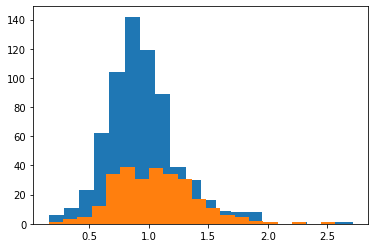

In [60]:
plt.hist(np.array(errors_filtered)[(lens_user[2] == 'M').to_numpy()], bins = 20)
#plt.show()
plt.hist(np.array(errors_filtered)[(lens_user[2] == 'F').to_numpy()], bins = 20)
plt.show()

We cannot identify specific trends within different user features